In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('flukaRunsTyped.csv', dtype='float64')

In [3]:
trainRatio = 0.8
# x is the tracklength in each bin
# y is the class label
xfull = df.to_numpy()[:,:200]
# add log energy
logE = np.log(df.to_numpy()[:,500])
xfull = np.column_stack((xfull,logE)) 
yfull = df.to_numpy()[:,501:507]
# decode the one hot encoded labels so RandomForestClassifier can use them
yfull = np.array([list(yfull[i]).index(1) for i in range(yfull.shape[0])])
# make array for stratifying based off energy and particle type
stratify_array = np.column_stack((yfull,logE)) 
xtrain, xtest, ytrain, ytest  = train_test_split(
    xfull, yfull, train_size=trainRatio, 
    stratify=stratify_array, shuffle=True, random_state=3)

In [12]:
in_size = xtrain.shape[1]
numEpochs = 180
batchSize = 500

model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_size,)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(400, activation='tanh'),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(6,activation=None)
])
model.load_weights('./modelClassifierWeights')
model.pop()
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(6,activation=None))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# lInput = keras.Input(shape=(in_size,))
# l1 = keras.layers.Dense(128, activation='relu',name='1')(lInput)
# lFinal = keras.layers.Dense(6,name='Final')(l1)
# # Full autoencoder
# finalModel = keras.Model(lInput, lFinal)
# opt = keras.optimizers.legacy.Adam(learning_rate=0.1)
# finalModel.compile(optimizer=opt,
#                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True))
# finalModel.fit(xtrain, ytrain, epochs=numEpochs, batch_size=batchSize, 
#                  shuffle=True)

In [13]:
model.fit(xtrain, ytrain, epochs=numEpochs, batch_size=batchSize, shuffle=True)

Epoch 1/180
96/96 [==============================] - 1s 8ms/step - loss: 1.7536 - accuracy: 0.2254
Epoch 2/180
96/96 [==============================] - 1s 8ms/step - loss: 1.7195 - accuracy: 0.2477
Epoch 3/180
96/96 [==============================] - 1s 8ms/step - loss: 1.7042 - accuracy: 0.2569
Epoch 4/180
96/96 [==============================] - 1s 9ms/step - loss: 1.7008 - accuracy: 0.2577
Epoch 5/180
96/96 [==============================] - 1s 9ms/step - loss: 1.6919 - accuracy: 0.2655
Epoch 6/180
96/96 [==============================] - 1s 8ms/step - loss: 1.6874 - accuracy: 0.2699
Epoch 7/180
96/96 [==============================] - 1s 8ms/step - loss: 1.6789 - accuracy: 0.2715
Epoch 8/180
96/96 [==============================] - 1s 8ms/step - loss: 1.6839 - accuracy: 0.2706
Epoch 9/180
96/96 [==============================] - 1s 9ms/step - loss: 1.6750 - accuracy: 0.2764
Epoch 10/180
96/96 [==============================] - 1s 9ms/step - loss: 1.6701 - accuracy: 0.2789
Epoch 11/

In [14]:
model.save_weights('./modelClassifierWeights')

In [21]:
yhat = model.predict(xtest)
yhat = tf.math.softmax(yhat,axis=1)

375/375 [==============================] - 1s 1ms/step


In [54]:
cmat = confusion_matrix(ytest,np.argmax(yhat,axis=1))
accuracy_score(ytest,np.argmax(yhat,axis=1)),cmat

(0.21483333333333332,
 array([[300, 432, 277, 249, 458, 284],
        [294, 389, 305, 263, 450, 299],
        [231, 286, 457, 247, 397, 382],
        [243, 303, 226, 344, 451, 433],
        [268, 330, 196, 262, 634, 310],
        [225, 272, 305, 340, 404, 454]]))

In [55]:
np.sum(cmat)

12000

Text(0.5, 1.0, 'Confusion matrix (full data set)\nKey:{0: $\\pi^+$, 1: $\\pi^-$, 2: $K^0_L$, 3: $p$, 4: $\\bar{p}$, 5: $n$}')

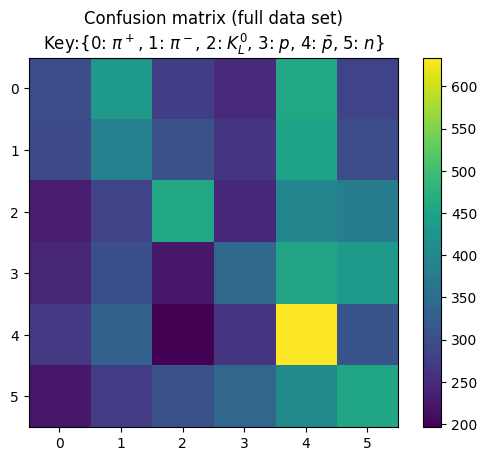

In [53]:
plt.imshow(cmat)
plt.colorbar()
plt.title('Confusion matrix (full data set)\n' + r'Key:{0: $\pi^+$, 1: $\pi^-$, 2: $K^0_L$, 3: $p$, 4: $\bar{p}$, 5: $n$}')
plt.show()

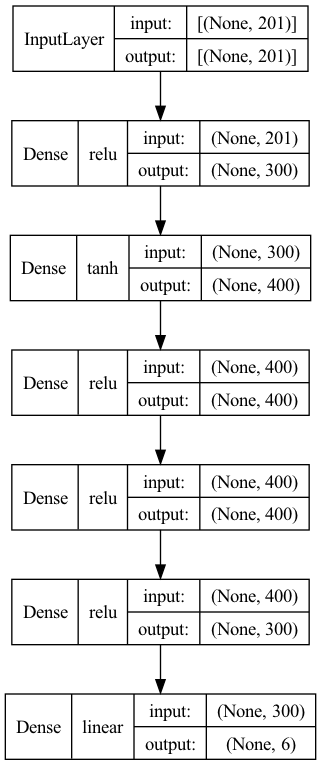

In [56]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, 
                          show_layer_activations=True)

In [24]:
maxes = np.max(yhat,axis=0)
indices = [list(yhat[:,i]).index(maxes[i]) for i in range(6)]
particle_types = ['PION','PION-','KAONLONG','PROTON','APROTON','NEUTRON']

In [25]:
indices,maxes

([416, 201, 6802, 2129, 9533, 824],
 array([1., 1., 1., 1., 1., 1.], dtype=float32))

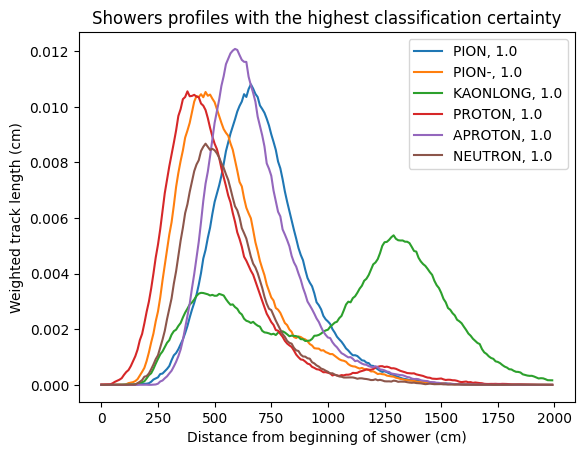

In [29]:
xvals = np.arange(500)[:200]

for i in range(len(indices)):
    plt.plot(xvals*10,xtest[indices[i],:200],label=particle_types[i]+', '+str(maxes[i]))
plt.legend()
plt.title('Showers profiles with the highest classification certainty')
plt.xlabel('Distance from beginning of shower (cm)')
plt.ylabel('Weighted track length (cm)')
plt.show()

In [27]:
typeNum=0
indexes = list(range(yhat.shape[0]))
sorted_list = sorted(zip(yhat.numpy()[:,typeNum],indexes))
sorted_list.reverse()

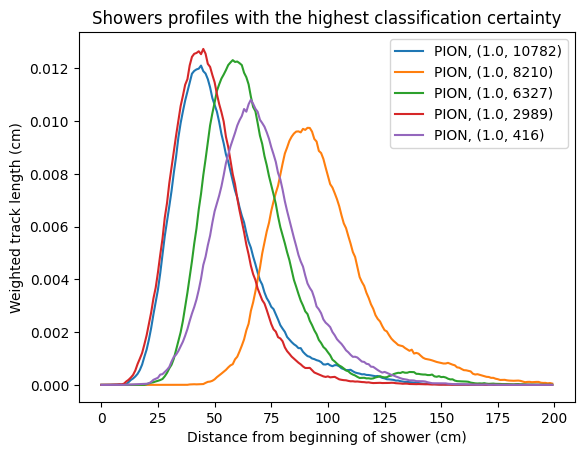

In [28]:
for i in range(5):
    plt.plot(xvals,xtest[sorted_list[i][1],:200],label=particle_types[typeNum]+', '+str(sorted_list[i]))
plt.legend()
plt.title('Showers profiles with the highest classification certainty')
plt.xlabel('Distance from beginning of shower (cm)')
plt.ylabel('Weighted track length (cm)')
plt.show()

In [6]:
(0.007537-0.005234)/0.007537

0.3055592410773518

In [9]:
np.log([10000,7000,3000])

array([9.21034037, 8.85366543, 8.00636757])

In [8]:
import numpy as np